In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [2]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import math
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [3]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_df['train'] = 1
test_df['train'] = 0

df = pd.concat([train_df, test_df], sort=False)

In [5]:
NAN = [(c,df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

In [6]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values('percentage', ascending=False)

,column_name,percentage
72,PoolQC,99.657417
74,MiscFeature,96.402878
6,Alley,93.216855
73,Fence,80.438506


In [7]:
df = df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)

In [8]:
object_columns = df.select_dtypes(include=['object'])
numerical_columns = df.select_dtypes(exclude=['object'])

In [9]:
object_columns.isnull().sum()

MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64

In [10]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_columns[columns_None]= object_columns[columns_None].fillna('None')

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']

for c in columns_with_lowNA:
    object_columns[c].fillna(object_columns[c].mode()[0], inplace=True)

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [12]:
object_columns.isnull().sum()

MSZoning         0
Street           0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
dtype: int64

In [13]:
numerical_columns.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64

In [14]:
numerical_columns.GarageYrBlt.describe()

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64

In [15]:
numerical_columns[numerical_columns.GarageYrBlt > 2020]['GarageYrBlt']

1132    2207.0
Name: GarageYrBlt, dtype: float64

In [16]:
numerical_columns.loc[numerical_columns.GarageYrBlt > 2020,'GarageYrBlt'] = 2007

numerical_columns.GarageYrBlt.describe()

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


count    2760.000000
mean     1978.040942
std        25.206206
min      1895.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [17]:
print(numerical_columns.LotFrontage.median())
print(numerical_columns.GarageYrBlt.median())

68.0
1979.0


In [18]:
numerical_columns['LotFrontage'] = numerical_columns['LotFrontage'].fillna(68)
numerical_columns['GarageYrBlt'] = numerical_columns['GarageYrBlt'].fillna(1979)

<ipython-input-18-2a63f53b2b59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_columns['LotFrontage'] = numerical_columns['LotFrontage'].fillna(68)
<ipython-input-18-2a63f53b2b59>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_columns['GarageYrBlt'] = numerical_columns['GarageYrBlt'].fillna(1979)


In [19]:
numerical_columns.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt         0
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64

In [20]:
numerical_columns = numerical_columns.fillna(0)

In [21]:
numerical_columns.isnull().sum()

Id               0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
train            0
dtype: int64

In [22]:
object_columns.iloc[:,0]

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
1454    RM
1455    RM
1456    RL
1457    RL
1458    RL
Name: MSZoning, Length: 2919, dtype: object

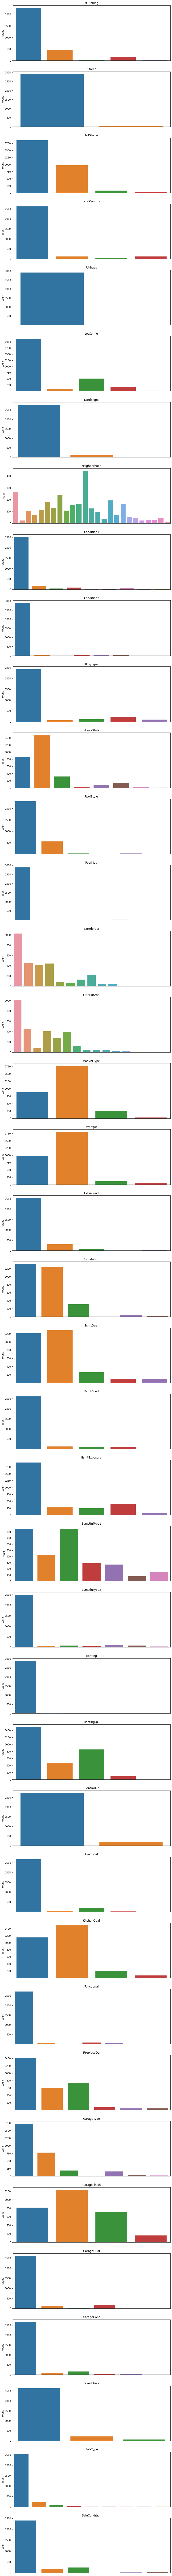

In [23]:
fig, axarr= plt.subplots(object_columns.columns.shape[0],1,figsize=(12,200))

for i in range(0,object_columns.columns.shape[0]):
    sns.countplot(object_columns.iloc[:,i], ax=axarr[i]).set_title(object_columns.columns[i])
    axarr[i].set_xticks([])
    axarr[i].axes.xaxis.set_visible(False)

In [24]:
object_columns = object_columns.drop(['Street','Utilities', 'Condition2', 'RoofMatl','Heating'], axis=1)

In [25]:
object_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2919 non-null   object
 1   LotShape       2919 non-null   object
 2   LandContour    2919 non-null   object
 3   LotConfig      2919 non-null   object
 4   LandSlope      2919 non-null   object
 5   Neighborhood   2919 non-null   object
 6   Condition1     2919 non-null   object
 7   BldgType       2919 non-null   object
 8   HouseStyle     2919 non-null   object
 9   RoofStyle      2919 non-null   object
 10  Exterior1st    2919 non-null   object
 11  Exterior2nd    2919 non-null   object
 12  MasVnrType     2919 non-null   object
 13  ExterQual      2919 non-null   object
 14  ExterCond      2919 non-null   object
 15  Foundation     2919 non-null   object
 16  BsmtQual       2919 non-null   object
 17  BsmtCond       2919 non-null   object
 18  BsmtExposure   2919 non-null

In [26]:
numerical_columns['TotalSF'] = numerical_columns['TotalBsmtSF'] + numerical_columns['1stFlrSF'] + numerical_columns['2ndFlrSF']

numerical_columns['TotalSF'].describe()

count     2919.00000
mean      2547.48270
std        805.12084
min        334.00000
25%       2000.00000
50%       2448.00000
75%       2991.50000
max      11752.00000
Name: TotalSF, dtype: float64

In [27]:
numerical_columns['HouseAge'] = numerical_columns['YrSold'] - numerical_columns['YearBuilt']

numerical_columns['HouseAge'].describe()

count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: HouseAge, dtype: float64

In [28]:
numerical_columns[numerical_columns['HouseAge'] < 0]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,TotalSF,HouseAge
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,17000,10,2007,0.0,0,10190.0,-1


In [29]:
numerical_columns.loc[numerical_columns.HouseAge < 0,'HouseAge'] = 0
numerical_columns['HouseAge'].describe()

count    2919.000000
mean       36.480301
std        30.335764
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: HouseAge, dtype: float64

In [30]:
numerical_columns['OverallRtg'] = numerical_columns['OverallQual'] + numerical_columns['OverallCond']
numerical_columns['OverallRtg'].describe()

count    2919.000000
mean       11.653649
std         1.712435
min         2.000000
25%        11.000000
50%        12.000000
75%        13.000000
max        19.000000
Name: OverallRtg, dtype: float64

In [31]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
object_columns['ExterQual'] = object_columns['ExterQual'].map(bin_map)
object_columns['ExterCond'] = object_columns['ExterCond'].map(bin_map)
object_columns['BsmtCond'] = object_columns['BsmtCond'].map(bin_map)
object_columns['BsmtQual'] = object_columns['BsmtQual'].map(bin_map)
object_columns['HeatingQC'] = object_columns['HeatingQC'].map(bin_map)
object_columns['KitchenQual'] = object_columns['KitchenQual'].map(bin_map)
object_columns['FireplaceQu'] = object_columns['FireplaceQu'].map(bin_map)
object_columns['GarageQual'] = object_columns['GarageQual'].map(bin_map)
object_columns['GarageCond'] = object_columns['GarageCond'].map(bin_map)
object_columns['CentralAir'] = object_columns['CentralAir'].map(bin_map)
object_columns['LotShape'] = object_columns['LotShape'].map(bin_map)
object_columns['BsmtExposure'] = object_columns['BsmtExposure'].map(bin_map)
object_columns['BsmtFinType1'] = object_columns['BsmtFinType1'].map(bin_map)
object_columns['BsmtFinType2'] = object_columns['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
object_columns['PavedDrive'] = object_columns['PavedDrive'].map(PavedDrive)

In [32]:
object_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       2919 non-null   object
 1   LotShape       2919 non-null   int64 
 2   LandContour    2919 non-null   object
 3   LotConfig      2919 non-null   object
 4   LandSlope      2919 non-null   object
 5   Neighborhood   2919 non-null   object
 6   Condition1     2919 non-null   object
 7   BldgType       2919 non-null   object
 8   HouseStyle     2919 non-null   object
 9   RoofStyle      2919 non-null   object
 10  Exterior1st    2919 non-null   object
 11  Exterior2nd    2919 non-null   object
 12  MasVnrType     2919 non-null   object
 13  ExterQual      2919 non-null   int64 
 14  ExterCond      2919 non-null   int64 
 15  Foundation     2919 non-null   object
 16  BsmtQual       2919 non-null   int64 
 17  BsmtCond       2919 non-null   int64 
 18  BsmtExposure   2919 non-null

In [33]:
rest_object_columns = object_columns.select_dtypes(include=['object'])
#Using One hot encoder
object_columns = pd.get_dummies(object_columns, columns=rest_object_columns.columns) 

In [34]:
object_columns.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,4,2,4,2,2,6,1,4,1,...,0,0,0,1,0,0,0,0,1,0
1,3,2,2,4,2,4,5,1,4,1,...,0,0,0,1,0,0,0,0,1,0
2,2,4,2,4,2,2,6,1,4,1,...,0,0,0,1,0,0,0,0,1,0
3,2,2,2,2,4,2,5,1,4,1,...,0,0,0,1,1,0,0,0,0,0
4,2,4,2,4,2,3,6,1,4,1,...,0,0,0,1,0,0,0,0,1,0


In [35]:
object_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 164 entries, LotShape to SaleCondition_Partial
dtypes: int64(15), uint8(149)
memory usage: 869.6 KB


In [36]:
df_final = pd.concat([object_columns, numerical_columns], axis=1,sort=False)
df_final.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,TotalSF,HouseAge,OverallRtg
0,3,4,2,4,2,2,6,1,4,1,...,0,0,0,2,2008,208500.0,1,2566.0,5,12
1,3,2,2,4,2,4,5,1,4,1,...,0,0,0,5,2007,181500.0,1,2524.0,31,14
2,2,4,2,4,2,2,6,1,4,1,...,0,0,0,9,2008,223500.0,1,2706.0,7,12
3,2,2,2,2,4,2,5,1,4,1,...,0,0,0,2,2006,140000.0,1,2473.0,91,12
4,2,4,2,4,2,3,6,1,4,1,...,0,0,0,12,2008,250000.0,1,3343.0,8,13


In [37]:
df_final = df_final.drop(['Id',],axis=1)

df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train',],axis=1)

In [38]:
df_train.to_csv('train_clean.csv', index=False)
df_test.to_csv('test_clean.csv', index=False)

In [39]:
target= df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

In [40]:
x_train,x_test,y_train,y_test = train_test_split(df_train,target,test_size=0.33,random_state=0)

In [41]:
xgb =XGBRegressor( booster='gbtree', 
            colsample_bylevel=1,
            colsample_bynode=1, 
            colsample_bytree=0.6, 
            gamma=0,
            importance_type='gain',
            learning_rate=0.01, 
            max_delta_step=0,
            max_depth=4, 
            min_child_weight=1.5, 
            n_estimators=2400,
            n_jobs=1, 
            nthread=None, 
            objective='reg:linear',
            reg_alpha=0.6, 
            reg_lambda=0.6, 
            scale_pos_weight=1, 
            silent=None, 
            subsample=0.8, 
            verbosity=1)


lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

In [42]:
#Fitting
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')

[16:45:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [43]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)

In [44]:
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))

Root Mean Square Error test = 27062.37430815939
Root Mean Square Error test = 27156.86647245314


In [45]:
xgb.fit(df_train, target)
lgbm.fit(df_train, target,eval_metric='rmse')

[16:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.4, learning_rate=0.01, max_bin=200,
              n_estimators=12000, num_leaves=4, objective='regression')

In [46]:
predict4 = lgbm.predict(df_test)
predict3 = xgb.predict(df_test)
predict_y = ( predict3*0.5 + predict4 * 0.5)

In [47]:
submission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": predict_y
    })
submission.to_csv('submission.csv', index=False)